In [1]:
!nvidia-smi

Thu Aug 10 16:08:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:41:00.0 Off |                    0 |
| N/A   44C    P0              87W / 500W |      4MiB / 81920MiB |      0%   E. Process |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import bson
import click
import os
import numpy as np
import matplotlib.pyplot as plt
import wandb

import itertools as it
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix
from tensorflow_probability.substrates import jax as tfp
from tqdm.auto import trange

from dtd.model4d import DirichletTuckerDecomp

tfd = tfp.distributions

/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def load_data(data_dir):
    # Load te drug ids ((M,) array of ints)
    y = np.load(os.path.join(data_dir, "drug_ids.npy"))

    # read in behav data
    with open(os.path.join(data_dir, "behav_data.bson"), 'rb') as f:
        data = bson.decode_all(f.read())
    
    X = np.reshape(np.frombuffer(data[0]['Xb']['data'], dtype=np.float64), data[0]['Xb']['size'], order='F').astype(np.float32)
    
    # Behavior tensor X is mice x syllables x positions x epochs
    # Permute to mice x epochs x positions x syllables
    X = np.transpose(X, (0, 3, 2, 1))
    
    # Permute the syllables
    perm = np.array([2, 45, 32, 33, 20, 23, 31, 47, 6, 25, 10, 17, 42, 12, 30, 36, 28, 34, 49, 13, 44, 7, 16, 15, 29, 48, 37, 38, 8, 24, 39, 43, 1, 26, 11, 19, 9, 40, 27, 21, 3, 18, 35, 4, 14, 5, 41, 22, 46, 50]) - 1
    X = X[..., perm]
    return X, y


def make_mask(X, key=0, train_frac=0.8):
    """## Split the data into train and test"""
    M, N, P, S = X.shape
    key = jr.PRNGKey(key)
    mask = tfd.Bernoulli(probs=train_frac).sample(seed=key, sample_shape = (M, N)).astype(bool)
    return mask


def fit_model(key, X, mask, K_M, K_N, K_P, K_S, alpha, num_iters):
    M, N, P, S = X.shape
    C = X[0,0].sum()

    # Construct a model
    model = DirichletTuckerDecomp(C, K_M, K_N, K_P, K_S, alpha=alpha)
    # Initialize the parameters randomly
    print("initializing model")
    init_params = model.sample_params(key, M, N, P, S)
    print("done")

    # Fit the model with EM
    params, lps = model.fit(X, mask, init_params, num_iters)

    # scale = M * N * P
    # plt.plot(jnp.array(lps) / scale)
    # plt.xlabel("iteration")
    # plt.ylabel("log joint prob (per entry)")

    # Compute test LL
    print("computing pct_dev")
    test_ll = model.heldout_log_likelihood(X, mask, params)

    # Make a baseline of average syllable usage in each epoch
    # NOTE: ignores the multinomial normalizing constant, like `heldout_log_likelihood`
    baseline_probs = jnp.mean(X[mask], axis=0) + alpha
    baseline_probs /= baseline_probs.sum()
    baseline_test_ll = jnp.sum(X[~mask] * jnp.log(baseline_probs))

    # Compute the test log likelihood under the saturated model
    sat_probs = X[~mask] / X[~mask].sum(axis=(-1, -2), keepdims=True)
    sat_test_ll = jnp.sum(X[~mask] * jnp.log(sat_probs))

    pct_dev = (test_ll - baseline_test_ll) / (sat_test_ll - baseline_test_ll)
    print("done")

    return model, params, lps, pct_dev


def plot_results(X, y, model, params):
    # Compute the reconstruction
    X_hat = model.reconstruct(params)

    # Plot the true and reconstructed data for mouse `m`
    m = 0
    n = 0
    fig, axs = plt.subplots(3, 1)
    im = axs[0].imshow(X[m, n], aspect="auto", interpolation="none")
    plt.colorbar(im)
    im = axs[1].imshow(X_hat[m, n], aspect="auto", interpolation="none")
    plt.colorbar(im)
    im = axs[2].imshow(X[m, n] - X_hat[m, n], aspect="auto", interpolation="none")
    plt.colorbar(im)

    """### Look at the factors"""
    G, Psi, Phi, Theta, Lambda = params

    # Plot the position topics
    plt.figure()
    plt.imshow(Theta, aspect="auto", interpolation="none")
    plt.xlabel("position")
    plt.ylabel("topics")
    plt.colorbar()

    # Plot the syllable topics
    syll_groups = np.array([2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) -1
    group_bounds = np.cumsum(np.bincount(syll_groups)[:-1])

    plt.figure()
    plt.imshow(Lambda, aspect="auto", interpolation="none")
    for bound in group_bounds:
        plt.axvline(bound-.5, color='r')
    plt.xlabel("syllables")
    plt.ylabel("topics")
    plt.colorbar()

    # Plot the epoch loadings
    plt.figure()
    plt.imshow(Phi.T, aspect="auto", interpolation="none")
    plt.xlabel("epochs")
    plt.ylabel("loadings")
    plt.colorbar()

    # Plot the mouse loadings
    plt.figure()
    perm = jnp.argsort(y)
    bounds = jnp.cumsum(jnp.bincount(y)[1:-1])
    plt.imshow(Psi[perm], aspect="auto", interpolation="none")
    for bound in bounds:
        plt.axhline(bound, color='r')
    plt.xlabel("loadings")
    plt.ylabel("mice")
    plt.colorbar()


def evaluate_prediction(Psi, y):
    """### Classify drug labels"""

    # normalize weights and factors
    def normalize_weights(features):
        features -= features.mean(axis=0)
        features /= features.std(axis=0)
        return features

    parameters = {"C":10 ** np.linspace(-15,15,num=31)}
    lr = LogisticRegression()
    gridsearch = GridSearchCV(lr, parameters)
    gridsearch.fit(normalize_weights(Psi), y)

    acc = gridsearch.best_score_
    classifier = gridsearch.best_estimator_
    y_pred = cross_val_predict(classifier, normalize_weights(Psi), y=y)
    confusion_mat = confusion_matrix(y, y_pred)

    return acc, confusion_mat

def run_one(data_dir, seed, km, kn, kp, ks, alpha, num_iters):
    key = jr.PRNGKey(seed)

    # Split the data deterministically
    X, y = load_data(data_dir)
    mask = make_mask(X, key=0)

    # Fit the model using the random seed provided
    model, params, lps, pct_dev = fit_model(key, X, mask, km, kn, kp, ks, alpha, num_iters)
    
    G, Psi, Phi, Theta, Lambda = params
    acc, confusion_matrix = evaluate_prediction(Psi, y)

    # Plot some results
    plot_results(X, y, model, params)

    # Finish the session
    print("pct_dev:", pct_dev)
    print("acc:", acc)


def run_sweep(data_dir, seed, km_min, km_max, kn_min, kn_max, kp_min, kp_max, ks_min, ks_max, k_step, num_restarts, alpha, num_iters):

    # Split the data deterministically
    X, y = load_data(data_dir)
    mask = make_mask(X, key=0)

    for km, kn, kp, ks in it.product(jnp.arange(km_min, km_max+1, step=k_step),
                                     jnp.arange(kn_min, kn_max+1, step=k_step),
                                     jnp.arange(kp_min, kp_max+1, step=k_step),
                                     jnp.arange(ks_min, ks_max+1, step=k_step),
                                     ):
        print("fitting model with km={}, kn={}, kp={} ks={}".format(km, kn, kp, ks))

        # start a new wandb run to track this script
        print("initializing wandb")
        wandb.init(
            # set the wandb project where this run will be logged
            project="serotonin-tucker-decomp-masked",

            # track hyperparameters and run metadata
            config={
                "K_M": km,
                "K_N": kn,
                "K_P": kp,
                "K_S": ks,
                "alpha": alpha,
                "num_restarts": num_restarts,            
                "num_iters": num_iters,
                "seed": seed,
                }
        )
        print("done")

        # Fit the model using the random seed provided
        pct_devs = []
        accs = []
        for i in range(num_restarts):
            key = jr.PRNGKey(seed)
            model, params, lps, pct_dev = fit_model(key, X, mask, km, kn, kp, ks, alpha, num_iters)
            acc, confusion_matrix = evaluate_prediction(params["Psi"], y)

            pct_devs.append(pct_dev)
            accs.append(acc)
            seed += 1

        # Finish the session
        wandb.run.summary["pct_dev_mean"] = jnp.array(pct_devs).mean()
        wandb.run.summary["pct_dev_std"] = jnp.array(pct_devs).std()
        wandb.run.summary["acc_mean"] = jnp.array(accs).mean()
        wandb.run.summary["acc_std"] = jnp.array(accs).std()
        wandb.finish()

initializing model
done


itr 0000: lp: -5.8700
itr 0100: lp: -5.3757
itr 0200: lp: -5.3558
itr 0300: lp: -5.3525
itr 0400: lp: -5.3512
itr 0500: lp: -5.3504
itr 0600: lp: -5.3500
itr 0700: lp: -5.3497
itr 0800: lp: -5.3496
itr 0900: lp: -5.3494
computing pct_dev
done
pct_dev: 0.38871115
acc: 0.44634581105169346


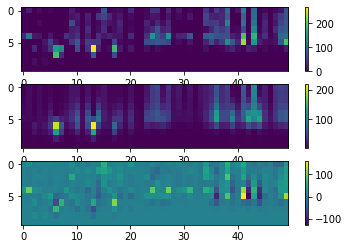

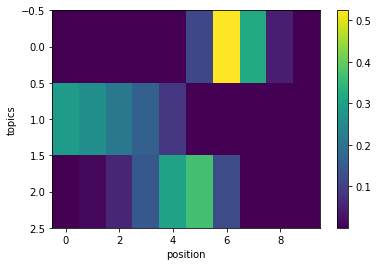

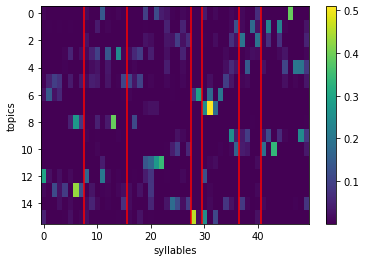

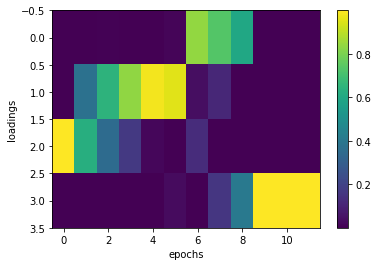

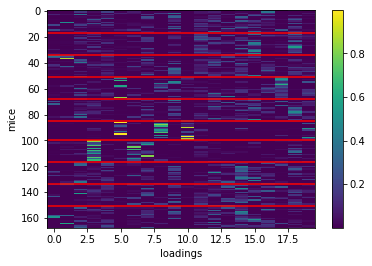

In [4]:
run_one(
    data_dir="/home/groups/swl1/swl1",
    seed=0, 
    km=20, 
    kn=4, 
    kp=3, 
    ks=16, 
    alpha=1.1, 
    num_iters=1000
)